# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
# # in google colab uncomment this

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# os.system('python -m pip install -U pygame --user')

# print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

entry_point is :gym.envs.classic_control:CartPoleEnv
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jim/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(require = False)


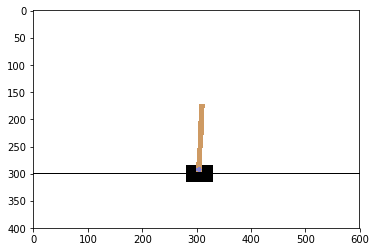

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [20]:
from mxnet.gluon.nn import HybridSequential as Sequential, Dense 
import mxnet
from mxnet import nd

In [21]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
# < YOUR CODE HERE: define a neural network that predicts policy logits >

model = Sequential()
model.add(Dense(2, activation="relu"))
model.add(Dense(3, activation="relu"))
model.add(Dense(2))
# init
model.initialize(init = mxnet.init.Xavier())

#### Predict function

In [22]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    #<your code here >
    states = nd.array(states)
    logits = model(states)
    policy = nd.softmax(logits)
    #log_policy = nd.log_softmax(logits)
    return policy.asnumpy()


In [24]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
print(test_probas)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], env.action_space.n), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

[[0.5        0.5       ]
 [0.49948496 0.500515  ]
 [0.4996332  0.50036687]
 [0.5        0.5       ]
 [0.50199145 0.49800855]]


### Play the game

We can now use our newly built agent to play the game.

In [25]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice([0,1], size = 1, p = action_probs)[0]  # < your code >
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [27]:
# test it
states, actions, rewards = generate_session()
print(states,actions,rewards)

[array([0.01998794, 0.0226609 , 0.01560493, 0.0126363 ]), array([ 0.02044116,  0.21755562,  0.01585765, -0.27508252]), array([ 0.02479227,  0.41244778,  0.010356  , -0.56272204]), array([ 0.03304122,  0.21718205, -0.00089844, -0.26679454]), array([ 0.03738486,  0.02207293, -0.00623433,  0.02560487]), array([ 0.03782632,  0.21728373, -0.00572223, -0.26903851]), array([ 0.042172  ,  0.0222439 , -0.011103  ,  0.02183411]), array([ 0.04261688, -0.17271707, -0.01066632,  0.31099333]), array([ 0.03916253, -0.36768545, -0.00444645,  0.60029342]), array([ 0.03180883, -0.17250158,  0.00755942,  0.30621325]), array([0.02835879, 0.02251184, 0.01368368, 0.01592393]), array([ 0.02880903, -0.17280365,  0.01400216,  0.31289262]), array([ 0.02535296, -0.36812225,  0.02026001,  0.60995829]), array([ 0.01799051, -0.56352145,  0.03245918,  0.90895299]), array([ 0.00672008, -0.75906736,  0.05063824,  1.21165867]), array([-0.00846126, -0.95480511,  0.07487141,  1.51977021]), array([-0.02755737, -0.76066384

### Computing cumulative rewards

In [28]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    #<your code here >
    rewards_list = []
    m = len(rewards)
    print('rewards len = {}'.format(m))
    reverse_rewards = rewards.copy()
    reverse_rewards.reverse()
    for i in np.arange(m):
        R_t = 0
        p = 0
        for r_t_1 in reverse_rewards:
            power = (m - i - p - 1)
            #print('r_t_1 = {}, power = {}'.format(r_t_1, power))
            R_t += gamma ** power * r_t_1
            p += 1
            if (m - p) == i :
                break
        #print('add one = {}'.format(R_t))
        rewards_list.append(R_t)
    #print(rewards_list)
    # < array of cumulative rewards >
    return rewards_list

In [29]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

rewards len = 21
rewards len = 100
rewards len = 7
rewards len = 7
rewards len = 7
looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [31]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    '''
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    '''
    y_one_hot = nd.one_hot(indices = y_tensor, depth = ndims)
    return y_one_hot
print(to_one_hot(nd.array([1,2,3]),10))


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
<NDArray 3x10 @cpu(0)>


In [70]:
from mxnet.gluon import Trainer

# Your code: define optimizers
# optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = nd.array(states, dtype='float32')
    actions = nd.array(actions, dtype='int32')
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = nd.array(cumulative_returns, dtype='float32')

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    #print(logits)
    probs = nd.softmax(logits)
    log_probs = nd.log_softmax(logits)

    assert all(isinstance(v, nd.NDArray) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = nd.sum(log_probs * to_one_hot(actions, env.action_space.n), 
                                   axis = 1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = mxnet.gluon.loss.SoftmaxCrossEntropyLoss() #< your code >
    #loss =  entropy * nd.norm(cumulative_returns)   #< your code >
    lr = 0.1
    optimizer = 'adam'
    optimizer_params={'learning_rate': lr}
    all_weights = model.collect_params()
    trainer = Trainer(params = all_weights, optimizer = optimizer, optimizer_params = optimizer_params)
    # Gradient descent step
    # < your code >
    epochs = 1
    batch_size = states.shape[0]
    for epoch in range(epochs):
        #tic = time.time()
        #btic = time.time()
        #accuracy.reset()
        #
        data = states
        label = actions
        with mxnet.autograd.record():
            outputs = model(data)
            entropy_out = entropy(outputs, label)
            loss_out = nd.mean(entropy_out * outputs - nd.norm(cumulative_returns))
        mxnet.autograd.backward(loss_out)
        trainer.step(batch_size)
        #accuracy.update([label], [outputs])
   
    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [71]:
for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

rewards len = 9


MXNetError: Traceback (most recent call last):
  File "src/operator/numpy/linalg/./../../tensor/elemwise_binary_broadcast_op.h", line 68
MXNetError: Check failed: l == 1 || r == 1: operands could not be broadcast together with shapes [9] [9,2]

### Video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be the _last_ video. Try other indices